## The Mood of the News

In [1]:
#Dependencies
import pandas as pd
import tweepy
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Target Search Term
target_user = ("@BBCNews", "@CNNbrk", "@CBSNews","@FoxNews", "@nytimes")

# Array to hold sentiments
sentiments = []

# Convert tweet timestamps to datetime objects that can be manipulated by Python
converted_timestamps = []

# Variables for holding sentiments
compound_list = []

# Counter
counter = 1

# Loop through all target users
for target in target_user:

    # Variable for holding the oldest tweet
    oldest_tweet = None

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    neutral_list = []
    negative_list = []
    
    
    # Get all tweets from home feed
    public_tweets = api.user_timeline(target, count=100, result_type="recent", max_id=oldest_tweet)

    # Loop through all tweets
    for tweet in public_tweets:
            
        #Convert the raw tweet time to correct datetime stamp.
        converted_time = datetime.strptime(tweet["created_at"], "%a %b %d %H:%M:%S %z %Y")

        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(tweet["text"])
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]
    
        # Add sentiments for each tweet into an array
        sentiments.append({"News Source": target,
                       "Date/Time": converted_time, 
                        "Compound": compound,
                        "Positive": pos,
                        "Neutral": neu,
                        "Negative": neg,
                        "Tweet": tweet["text"],
                        "Tweets Ago": counter})
        # Add to counter 
        counter = counter + 1

In [3]:
#Need to put tweet in df with time stamp, sentiment analysis and tweet. 
sentiments_df = pd.DataFrame.from_dict(sentiments)
sentiments_df.head()

,Compound,Date/Time,Negative,Neutral,News Source,Positive,Tweet,Tweets Ago
0,-0.6908,2017-12-01 22:14:59+00:00,0.299,0.701,@BBCNews,0.0,"Saturday's Daily Star: ""Murder on the danceflo...",1
1,0.0000,2017-12-01 22:14:54+00:00,0.000,1.000,@BBCNews,0.0,"Saturday's Daily Telegraph: ""Trump aide turns ...",2
2,0.0000,2017-12-01 22:14:54+00:00,0.000,1.000,@BBCNews,0.0,"Saturday's Sun: ""Mega star!"" #tomorrowspaperst...",3
3,0.0000,2017-12-01 22:14:49+00:00,0.000,1.000,@BBCNews,0.0,"Saturday's Daily Mirror: ""The minister for por...",4
4,-0.3400,2017-12-01 22:10:39+00:00,0.255,0.745,@BBCNews,0.0,Kaspersky Labs: Warning over Russian anti-viru...,5


In [4]:
#Make the df look nice.  
news_sentiments = pd.DataFrame(sentiments_df, columns= ["News Source", "Date/Time", "Compound","Positive",
                                                        "Neutral", "Negative", "Tweet", "Tweets Ago"])
news_sentiments.head()

,News Source,Date/Time,Compound,Positive,Neutral,Negative,Tweet,Tweets Ago
0,@BBCNews,2017-12-01 22:14:59+00:00,-0.6908,0.0,0.701,0.299,"Saturday's Daily Star: ""Murder on the danceflo...",1
1,@BBCNews,2017-12-01 22:14:54+00:00,0.0000,0.0,1.000,0.000,"Saturday's Daily Telegraph: ""Trump aide turns ...",2
2,@BBCNews,2017-12-01 22:14:54+00:00,0.0000,0.0,1.000,0.000,"Saturday's Sun: ""Mega star!"" #tomorrowspaperst...",3
3,@BBCNews,2017-12-01 22:14:49+00:00,0.0000,0.0,1.000,0.000,"Saturday's Daily Mirror: ""The minister for por...",4
4,@BBCNews,2017-12-01 22:10:39+00:00,-0.3400,0.0,0.745,0.255,Kaspersky Labs: Warning over Russian anti-viru...,5


In [5]:
#Export the dataframe to a csv file. 
news_sentiments.to_csv('New_Source_sentiments.csv', encoding='utf-8', index=False)

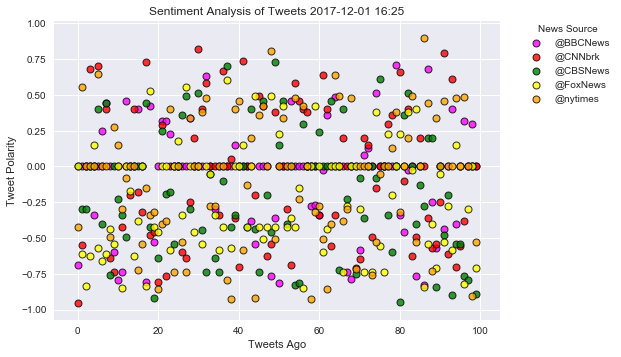

In [6]:
#Graph the 100 tweets from each news source with a timestamp "Tweets Ago". 

colors = ['magenta','red','green','yellow','orange']
plt.style.use('seaborn')
for i in np.arange(0,len(target_user)):
    news_source = news_sentiments.loc[news_sentiments["News Source"]==target_user[i]]
    news_source = news_source.sort_values("Tweets Ago")
    plt.scatter(np.arange(len(news_source["Compound"])), 
            news_source["Compound"], color = colors[i],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8,label= target_user[i])

plt.title(f"Sentiment Analysis of Tweets {datetime.now().strftime('%Y-%m-%d %H:%M')}")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad = 0.,title="News Source")

# Save the figure
plt.savefig("News_Tweets.png", bbox_inches='tight')

plt.show()

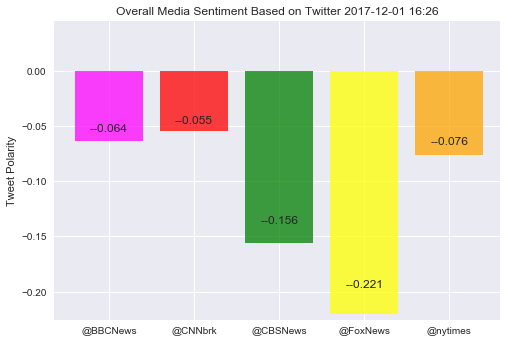

In [9]:
#Plot a bar graph showing the overall sentiment analysis of the 100 tweets for each news source.

plt.style.use('seaborn')
fig, ax = plt.subplots()
tick_locations = []
news_avg_cmpd = {}

for i in np.arange(0,len(target_user)):
    news_source = news_sentiments.loc[news_sentiments["News Source"]==target_user[i]]
    news_avg_cmpd[target_user[i]] = news_source["Compound"].mean()
    tick_locations.append(i + 0.4)

x_axis = np.arange(0, len(target_user) )
plt.xlim(-0.25, len(target_user))
plt.ylim(min(news_avg_cmpd.values()) - 0.005, max(news_avg_cmpd.values()) + 0.1)
plt.title(f"Overall Media Sentiment Based on Twitter {datetime.now().strftime('%Y-%m-%d %H:%M')}" )
plt.ylabel("Tweet Polarity")
plt.xticks(tick_locations, news_avg_cmpd, rotation="horizontal")
bar_graphs = plt.bar(x_axis, news_avg_cmpd.values(), color = colors, alpha=0.75, align="edge")

def bar_label(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.9*height,
                '-%.3f' %float(height), ha='center', va='bottom', fontsize=12)

bar_label(bar_graphs)

# Save the figure
plt.savefig("Overall_Media_Sentiment.png")


plt.show()